TODO:

- [ ] implement ring-all-reduce (and check it works)
- [ ] 

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import numpy as np

import itertools
from time import sleep, time
import toolz
import numpy as np

In [2]:
import distributed
distributed.__file__

'/Users/ssievert/Developer/dask/distributed/distributed/__init__.py'

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def get_model(model=None):
    if model is None:
        return Net()
    return getattr(torchvision.models, model)()

resnet_models = [m for m in dir(torchvision.models)
                 if 'resnet' in m and m != 'resnet']
models = [get_model(model=model) for model in resnet_models]

In [4]:
from types import SimpleNamespace
args = SimpleNamespace(batch_size=64, test_batch_size=1000,
                       epochs=2, lr=0.01, momentum=0.5,
                       no_cuda=True, seed=42, log_interval=80)
    
use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
from distributed import Client
import distributed as d
client = Client()
client

Client Scheduler: tcp://127.0.0.1:63415 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [6]:
# num_workers = 4
# model = get_model()
model = Net()
iters = 20

# Centralized implementation

In [7]:
from time import sleep

In [8]:
def train(model, device, data, target):
    model.train()
    
    data, target = data.to(device), target.to(device)
    # optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    # optimizer.step()
    return model

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
from ps import PS

In [17]:
def worker(ps, device, train_loader,
           worker_id=0, num_workers=1,
           iters=10):
    times = {'comm_grad': 0, 'compute_grad': 0, 'comm_model': 0}
    whole_start = time()
    
    step = -1
    while True:
        start = time()
        next_step = ps.step().result()
        if next_step != step:
            step = next_step
            model = ps.pull(step).result()
        # step, model = ps.pull_latest().result()
        times['comm_model'] += time() - start
        if step > iters:
            break
        # param_check = toolz.last(model.parameters())
        # check = param_check.detach().numpy().flat[:4]
        # print("worker {} iter {}, last params = {}".format(worker_id, step, check))
            
        data, target = next(iter(train_loader))
        start = time()
        model = train(model, device, data, target)
        grads = {name: p.grad.data for name, p in model.named_parameters()}
        times['compute_grad'] += time() - start
        
        start = time()
        ps.push(step, grads)
        times['comm_grad'] += time() - start
        
    params = [np.prod(tuple(p.size())) for p in model.parameters()]
    meta = {'compute_grad': times['compute_grad'] / iters,
            'comm_model': times['comm_model'] / iters,
            'comm_grad': times['comm_grad'] / iters,
            'avg_step_time': (time() - whole_start) / iters,
            'iters': iters,
            'num_workers': num_workers,
            'params': sum(params),
            'worker_id': worker_id}
    return meta

In [18]:
def train_centralized(client, model, args, num_workers, iters, batch_size=64):
    batch_size //= num_workers
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    device = torch.device("cuda" if use_cuda else "cpu")
    train_loader, model = client.scatter([train_loader, model])

    ps = client.gather(client.submit(PS, model, args, device,
                                     num_workers=num_workers,
                                     actor=True))
    futures = [client.submit(worker, ps, device, train_loader,
                             iters=iters,
                             worker_id=i, num_workers=num_workers)
               for i in range(num_workers)]
    meta = client.gather(futures)
    meta = [{'batch_size': batch_size, **m} for m in meta]
    return meta

In [19]:
meta = [train_centralized(client, model, args, num_workers, iters)
        for num_workers in [2, 4, 8]]

In [20]:
meta = [{'arch': 'centralized', **mi} for m in meta for mi in m]

In [21]:
all_meta = []

In [22]:
all_meta += meta

In [23]:
import pandas as pd
df = pd.DataFrame(all_meta)
df.head()

,arch,avg_step_time,batch_size,comm_grad,comm_model,compute_grad,iters,num_workers,params,worker_id
0,centralized,0.083139,32,0.000302,0.033593,0.030720,20,2,21840,0
1,centralized,0.074741,32,0.000333,0.024419,0.028673,20,2,21840,1
2,centralized,0.078234,16,0.000172,0.038030,0.030117,20,4,21840,0
3,centralized,0.079171,16,0.000178,0.035228,0.031369,20,4,21840,1
4,centralized,0.125385,16,0.000365,0.063749,0.042854,20,4,21840,2


Here's calling the train function. This can be called repeated times, since the function `worker` gets the latest model to start.

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

keep = df.drop(columns=['params', 'batch_size', 'iters', 'avg_step_time'])
melted = keep.melt(id_vars=['arch', 'num_workers', 'worker_id'],
                   value_name='time (s)')
melted.head()

,arch,num_workers,worker_id,variable,time (s)
0,centralized,2,0,comm_grad,0.000302
1,centralized,2,1,comm_grad,0.000333
2,centralized,4,0,comm_grad,0.000172
3,centralized,4,1,comm_grad,0.000178
4,centralized,4,2,comm_grad,0.000365


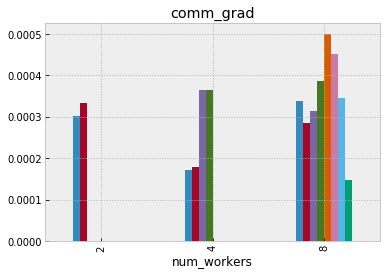

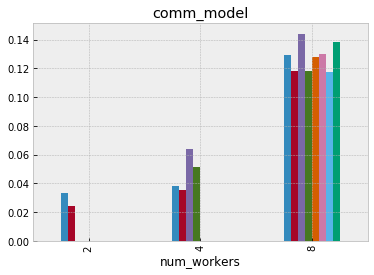

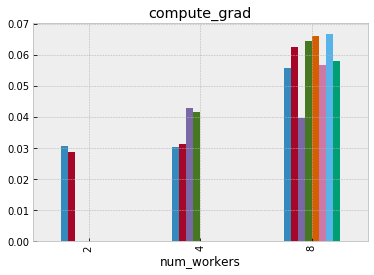

In [25]:
var = 'comm_grad'
for var in melted.variable.unique():
    show = melted[melted.variable == var]
    show = show.pivot_table(columns='worker_id', values='time (s)',
                     index='num_workers', aggfunc=np.mean)
    show.plot.bar(logy=False, legend=False, title=var)

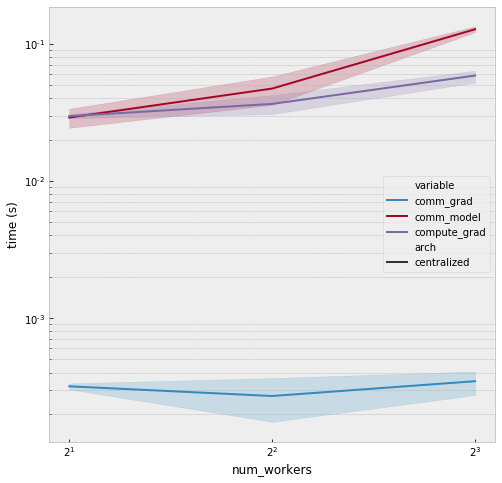

In [26]:
w = 8
fig, ax = plt.subplots(figsize=(w, w))
sns.lineplot(x='num_workers', y='time (s)',
             hue='variable', style='arch', data=melted)
ax.set_yscale("log")
ax.set_xscale("log", basex=2)
ax.grid(which='both')
plt.savefig('centralized.png', dpi=300)